In [1]:
import pandas as pd
import anndata as ad
from loguru import logger 
import time

import numpy as np
import tifffile

import matplotlib.pyplot as plt
import seaborn as sns

import shapely
import geopandas as gpd

import os
import sys
sys.path.append(os.path.abspath('../scripts'))
import utils
import importlib

import scimap as sm

Running SCIMAP  2.1.3


In [112]:
df = pd.read_csv("../data/processed/20241002_2104_adataobs_RCN.csv")

In [113]:
#subset to one image
image = 991

#subset some cells based on x,y coordinates
x_min = 20000
x_max = 25000
y_min = 20000
y_max = 25000

df_subset = df[(df.imageid == image) & 
            (df.X_centroid > x_min) & 
            (df.X_centroid < x_max) & 
            (df.Y_centroid > y_min) & 
            (df.Y_centroid < y_max)]

In [114]:
df_subset.shape

(433, 27)

In [121]:
#create numpy array of X and Y 
X = df_subset.X_centroid.values
Y = df_subset.Y_centroid.values
points = np.array([X,Y]).T

In [19]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [122]:
vor = scipy.spatial.Voronoi(points)

In [117]:
vor

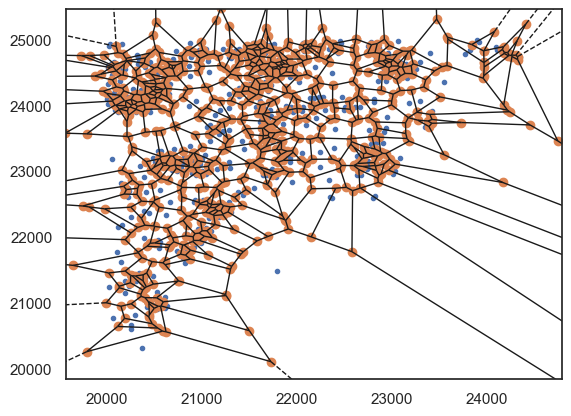

In [118]:
fig = voronoi_plot_2d(vor)
plt.show()

In [123]:
polygons = {}
for id, region_index in enumerate(vor.point_region):
    points = []
    for vertex_index in vor.regions[region_index]:
        if vertex_index != -1:  # the library uses this for infinity
            points.append(list(vor.vertices[vertex_index]))
    points.append(points[0])
    polygons[id]=points

In [124]:
polygons[0]

[[23051.709574763445, 24541.18507347932],
 [22971.450874246064, 24508.99529176768],
 [22956.6814777111, 24466.69295678068],
 [23049.146121360278, 24394.24993808958],
 [23090.869420679424, 24449.217740200667],
 [23051.709574763445, 24541.18507347932]]

In [125]:
df_subset.head()

,Unnamed: 0,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,...,DAPI_ratio,DAPI_ratio_pass_nottoolow,DAPI_ratio_pass_nottoohigh,DAPI_ratio_pass,imageid,phenotype,neigh_kmeans_k5,neigh_kmeans_k7,neigh_kmeans_k9,spatial_lda_kmeans_k7
440774,440774,491294.0,24508.815864,23045.615675,1059.0,41.001067,34.006208,0.558658,1.426667,123.840620,...,0.368614,True,True,True,991,Unknown,2,2,7,3
440775,440775,491296.0,24554.324719,21851.985411,2399.0,65.551986,48.742600,0.668656,0.110211,193.580736,...,0.653507,True,True,True,991,Unknown,2,6,0,2
440776,440776,491297.0,24552.115283,20194.260211,1518.0,55.141593,37.005226,0.741372,0.223127,157.053824,...,0.697483,True,True,True,991,Unknown,2,6,0,2
440777,440777,491298.0,24554.503089,20162.693892,1457.0,49.448124,38.072322,0.638111,-0.139633,145.740115,...,0.650948,True,True,True,991,COL1A1_cells,2,6,0,2
440778,440778,491300.0,24546.493724,21780.041841,717.0,32.709572,28.778712,0.475297,-1.212657,102.911688,...,0.688105,True,True,True,991,Unknown,2,6,0,2


In [24]:
import geopandas as gpd

In [38]:
from shapely.geometry import Polygon, MultiPolygon, box

In [27]:
# Function to convert Voronoi region to shapely polygon
def voronoi_region_to_polygon(vor, region):
    # Infinite region handling
    if -1 in region:
        return None  # Ignore regions with open boundaries
    else:
        polygon = Polygon([vor.vertices[i] for i in region])
        return polygon

# Get Voronoi regions and convert them to Shapely polygons
polygons = []
for region_index in vor.regions:
    if not -1 in region_index and len(region_index) > 0:  # Exclude empty/infinite regions
        poly = voronoi_region_to_polygon(vor, region_index)
        if poly is not None:
            polygons.append(poly)

In [39]:
boundary_box = box(x_min, y_min, x_max, y_max)

In [28]:
polygons

[<POLYGON ((21499.856 20574.985, 21254.865 21109.436, 20594.83 21014.63, 2056...>,
 <POLYGON ((19970.589 24767.979, 19818.798 24758.998, 20071.485 24602.618, 20...>,
 <POLYGON ((20086.646 24004.642, 19560.921 23578.068, 4593.178 22772.283, 200...>,
 <POLYGON ((20586.444 20568.116, 19788.32 20255.524, 20114.226 20639.47, 2053...>,
 <POLYGON ((20477.818 20680.793, 20187.057 20762.796, 20114.226 20639.47, 205...>,
 <POLYGON ((20565.412 20946.612, 20569.606 20951.614, 21499.856 20574.985, 21...>,
 <POLYGON ((22886.144 22958.703, 22918.032 23109.059, 22975.514 23183.666, 23...>,
 <POLYGON ((22964.325 23016.128, 30218.545 18947.582, 27635.208 20896.389, 24...>,
 <POLYGON ((22663.368 22741.069, 22586.293 22704.039, 22579.274 21776.177, 44...>,
 <POLYGON ((24255.276 24761.782, 24263.338 24743.331, 24322.874 24697.328, 24...>,
 <POLYGON ((20270.351 22863.616, 20176.873 22769.872, 19100.483 22532.312, 18...>,
 <POLYGON ((20440.395 20785.827, 20477.818 20680.793, 20187.057 20762.796, 20...>,
 <PO

In [40]:
filtered_gdf = gdf[gdf.geometry.apply(lambda poly: poly.within(boundary_box))]

<Axes: >

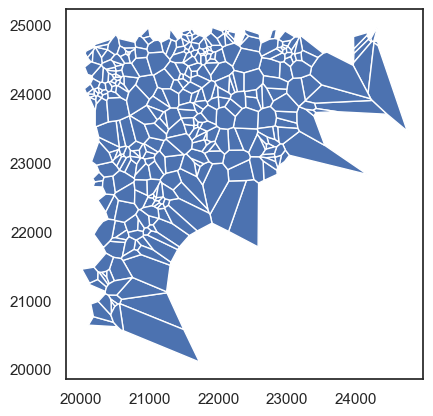

In [41]:
filtered_gdf.plot()

In [42]:
#export filtered_gdf to geojson
filtered_gdf.to_file("../data/geojson/20241002_2123_voronoi.geojson", driver='GeoJSON')

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/pyogrio/raw.py:698: UserWarning:

'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.



# try crowded area

In [126]:
#subset to one image
image = 991

#subset some cells based on x,y coordinates
x_min = 40000
x_max = 45000
y_min = 30000
y_max = 35000

df_subset = df[(df.imageid == image) & 
            (df.X_centroid > x_min) & 
            (df.X_centroid < x_max) & 
            (df.Y_centroid > y_min) & 
            (df.Y_centroid < y_max)]

boundary_box = box(x_min, y_min, x_max, y_max)

In [127]:
#create numpy array of X and Y 
X = df_subset.X_centroid.values
Y = df_subset.Y_centroid.values
points = np.array([X,Y]).T

In [128]:
vor = scipy.spatial.Voronoi(points)

In [146]:
# Function to convert Voronoi region to shapely polygon
def voronoi_region_to_polygon(vor, region):
    # Infinite region handling
    if -1 in region:
        return Polygon([])  # Add an empty polygon for infinite regions
    else:
        polygon = Polygon([vor.vertices[i] for i in region])
        return polygon

polygons = []
for region_index in vor.regions:
    if len(region_index) > 0:  # Exclude empty/infinite regions
        poly = voronoi_region_to_polygon(vor, region_index)
        if poly is not None:
            polygons.append(poly)

In [147]:
df_subset.head()

,Unnamed: 0,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,...,DAPI_ratio,DAPI_ratio_pass_nottoolow,DAPI_ratio_pass_nottoohigh,DAPI_ratio_pass,imageid,phenotype,neigh_kmeans_k5,neigh_kmeans_k7,neigh_kmeans_k9,spatial_lda_kmeans_k7
101722,101722,112720.0,30004.452643,44830.043502,1816.0,56.183535,41.701115,0.670145,0.077843,166.610173,...,0.332394,True,True,True,991,Cancer_cells,0,0,6,1
101732,101732,112730.0,30003.766595,44682.070664,1401.0,49.113786,37.564631,0.644210,-0.642698,147.923882,...,0.378497,True,True,True,991,Cancer_cells,1,5,4,6
101759,101759,112757.0,30008.297214,44562.904025,646.0,36.167505,23.472487,0.760794,-0.279291,104.468037,...,0.339142,True,True,True,991,CD4_Tcells,4,3,2,0
101765,101765,112763.0,30008.686667,44636.077333,750.0,40.045978,25.834082,0.764089,0.821729,112.225397,...,0.349955,True,True,True,991,Cancer_cells,1,5,2,6
101770,101770,112768.0,30010.494770,44512.354603,956.0,42.664336,29.439419,0.723786,0.053463,123.396970,...,0.318969,True,True,True,991,Cancer_cells,4,3,8,0


In [148]:
vor.points

array([[44830.0435022 , 30004.45264317],
       [44682.07066381, 30003.76659529],
       [44562.90402477, 30008.29721362],
       ...,
       [44104.9975    , 34968.857     ],
       [44196.97067669, 34970.16766917],
       [44141.01107266, 34982.62076125]])

In [152]:
vor.regions[2]

[11, -1, 3, 7]

In [151]:
polygons[2]

In [63]:
gdf = gpd.GeoDataFrame(geometry=polygons)

In [64]:
filtered_gdf = gdf[gdf.geometry.apply(lambda poly: poly.within(boundary_box))]

<Axes: >

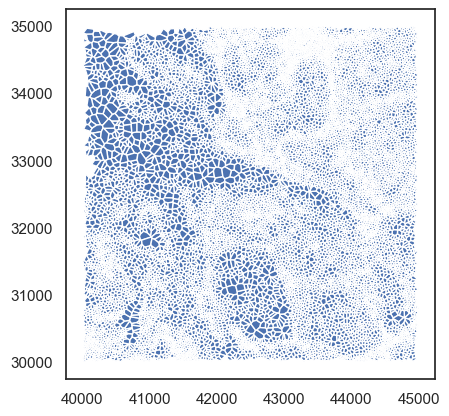

In [65]:
filtered_gdf.plot()

In [67]:
#export filtered_gdf to geojson
filtered_gdf.to_file("../data/geojson_vor/20241002_2214_voronoi.geojson", driver='GeoJSON')

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/pyogrio/raw.py:698: UserWarning:

'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.



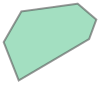

In [70]:
polygons[0]

In [72]:
# Assuming you have a GeoDataFrame 'gdf'
gdf_test = gpd.GeoDataFrame(data={
    'geometry': polygons[0],
    'classification': "Cancer_cell",
    'objectType': 'cell'
}, index=[0])

# Write to GeoJSON
gdf_test.to_file("your_file.geojson", driver="GeoJSON")

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/pyogrio/raw.py:698: UserWarning:

'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.



In [73]:
df

,Unnamed: 0,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,...,DAPI_ratio,DAPI_ratio_pass_nottoolow,DAPI_ratio_pass_nottoohigh,DAPI_ratio_pass,imageid,phenotype,neigh_kmeans_k5,neigh_kmeans_k7,neigh_kmeans_k9,spatial_lda_kmeans_k7
0,0,0.0,29410.806452,35874.857801,1519.0,98.696620,30.646839,0.950568,-1.524977,228.651804,...,0.291466,True,True,True,991,Cancer_cells,0,0,6,5
1,1,1.0,29445.080408,36162.243140,1567.0,50.422862,39.687556,0.616832,0.160002,148.710678,...,0.353388,True,True,True,991,Cancer_cells,0,5,1,6
2,2,2.0,29505.171707,38455.235122,1025.0,40.280587,34.195207,0.528513,-0.346644,131.438600,...,0.234700,True,True,True,991,Cancer_cells,0,0,6,1
3,3,3.0,29539.721673,35060.844867,1315.0,61.049935,28.208869,0.886848,-1.447088,151.254834,...,0.225623,True,True,True,991,CD4_Tcells,4,2,7,3
4,4,4.0,29982.642779,36765.660558,3656.0,84.178897,57.384893,0.731630,0.251203,243.379726,...,0.217717,True,True,True,991,Cancer_cells,0,0,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615228,1615228,1134342.0,27270.642157,37569.550980,1020.0,39.707795,32.947621,0.558132,-0.657307,121.639610,...,0.335935,True,True,True,992,Unknown,1,5,4,3
1615229,1615229,1134343.0,27274.343598,38996.906807,1234.0,42.622618,37.495770,0.475501,0.465532,133.781746,...,0.364614,True,True,True,992,Cancer_cells,0,0,1,5
1615230,1615230,1134344.0,27271.604926,37413.383251,1015.0,60.243974,22.812825,0.925530,-0.625325,144.509668,...,0.353360,True,True,True,992,Cancer_cells,1,5,4,5
1615231,1615231,1134345.0,27272.320411,38221.301424,1264.0,50.722945,32.740800,0.763775,-1.218716,143.681241,...,0.342360,True,True,True,992,Cancer_cells,0,0,6,5


# Create geodataframe with attributes in columns

In [91]:
#subset to one image
image = 991

#subset some cells based on x,y coordinates
x_min = 10000
x_max = 30000
y_min = 10000
y_max = 30000

df_subset = df[(df.imageid == image) & 
            (df.X_centroid > x_min) & 
            (df.X_centroid < x_max) & 
            (df.Y_centroid > y_min) & 
            (df.Y_centroid < y_max)]

In [92]:
X = df_subset.X_centroid.values
Y = df_subset.Y_centroid.values
points = np.array([X,Y]).T
vor = scipy.spatial.Voronoi(points)

In [93]:
# Function to convert Voronoi region to shapely polygon
def voronoi_region_to_polygon(vor, region):
    # Infinite region handling
    if -1 in region:
        return Polygon([])  # Add an empty polygon for infinite regions
    else:
        polygon = Polygon([vor.vertices[i] for i in region])
        return polygon

# Get Voronoi regions and convert them to Shapely polygons
polygons = []
for region_index in vor.regions:
    if len(region_index) > 0:  # Exclude empty regions
        poly = voronoi_region_to_polygon(vor, region_index)
        polygons.append(poly)  # Append the polygon (including empty polygons)

In [104]:
df_subset

,Unnamed: 0,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,...,DAPI_ratio,DAPI_ratio_pass_nottoolow,DAPI_ratio_pass_nottoohigh,DAPI_ratio_pass,imageid,phenotype,neigh_kmeans_k5,neigh_kmeans_k7,neigh_kmeans_k9,spatial_lda_kmeans_k7
15128,15128,17778.0,29529.047156,10412.012154,2057.0,62.799797,41.980014,0.743736,-0.049988,175.296465,...,0.162566,True,True,True,991,Unknown,2,6,0,2
39694,39694,44571.0,14713.984496,17295.396641,774.0,40.154328,25.393094,0.774652,0.940229,112.124892,...,0.773563,True,True,True,991,Unknown,2,6,0,2
39715,39715,44593.0,14715.218526,17622.418947,2375.0,65.793809,46.927795,0.700904,1.362290,186.610173,...,0.469336,True,True,True,991,Unknown,2,6,0,2
39725,39725,44604.0,14712.836066,17745.094503,2074.0,63.387790,43.369457,0.729301,1.362421,179.882251,...,0.478107,True,True,True,991,Unknown,2,6,0,2
39736,39736,44615.0,14713.861173,17858.762435,1347.0,52.940192,35.590636,0.740297,-1.435307,153.781746,...,0.601268,True,True,True,991,Unknown,2,6,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593703,593703,666426.0,29966.178546,29842.242621,1389.0,54.406490,33.218731,0.791966,-1.048145,147.053824,...,0.250234,True,True,True,991,Cancer_cells,0,0,6,1
593707,593707,666431.0,29967.023136,29951.304627,778.0,35.137870,28.565916,0.582310,-0.462959,106.911688,...,0.289460,True,True,True,991,CD4_Tcells,1,5,2,5
593727,593727,666470.0,29986.353155,29921.854369,824.0,43.864169,24.666078,0.826914,-1.370397,116.811183,...,0.261711,True,True,True,991,Cancer_cells,1,5,2,6
593736,593736,666483.0,29992.995820,29841.013584,957.0,52.679998,23.491024,0.895073,-1.224906,129.497475,...,0.230050,True,True,True,991,Cancer_cells,0,0,6,1


In [94]:
gdf = gpd.GeoDataFrame(geometry=polygons)
gdf.shape

(23721, 1)

In [95]:
df_subset.shape

(23721, 27)

In [90]:
df_subset.columns

Index(['Unnamed: 0', 'CellID', 'Y_centroid', 'X_centroid', 'Area',
       'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation',
       'Extent', 'Solidity', 'filter_by_ann', 'mean_DAPI_bg_abs_above_value',
       'mean_DAPI_bg_abs_below_value', 'Area_filter_nottoobig',
       'Area_filter_nottoolow', 'Area_filter', 'DAPI_ratio',
       'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh',
       'DAPI_ratio_pass', 'imageid', 'phenotype', 'neigh_kmeans_k5',
       'neigh_kmeans_k7', 'neigh_kmeans_k9', 'spatial_lda_kmeans_k7'],
      dtype='object')

In [99]:
# map information from df_subset to gdf
gdf['objectType'] = 'cell'
gdf['classification'] = df_subset['phenotype'].values

In [101]:
#filter out elongated polygons, after mapping data
boundary_box = box(x_min, y_min, x_max, y_max)
gdf = gdf[gdf.geometry.apply(lambda poly: poly.within(boundary_box))]

In [103]:
gdf.to_file("../data/geojson_vor/20241002_2250_voronoi_test.geojson", driver='GeoJSON')

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/pyogrio/raw.py:698: UserWarning:

'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.



In [ ]:
# there is an issue with mapping the right info to the right polygon

In [107]:
import pandas as pd
from shapely.geometry import Polygon
from scipy.spatial import Voronoi

def map_voronoi_polygons(df, vor):
    """
    Maps Voronoi polygons to DataFrame rows based on X, Y coordinates.
    
    Parameters:
        df (pd.DataFrame): DataFrame with 'X' and 'Y' columns for point coordinates.
        vor (Voronoi): Voronoi object generated from the same points.
        
    Returns:
        pd.DataFrame: The original DataFrame with an additional column 'polygon'
                    containing the corresponding Voronoi polygons.
    """
    # Function to convert Voronoi region to Shapely polygon
    def voronoi_region_to_polygon(vor, region):
        if -1 in region:
            return Polygon([])  # Empty polygon for infinite regions
        else:
            return Polygon([vor.vertices[i] for i in region])

    # Ensure that the points in the DataFrame are in the same order as Voronoi input points
    polygons = []
    
    for point_idx in range(len(df)):
        # The Voronoi region index is the same as the point index in the Voronoi object
        region_index = vor.point_region[point_idx]  # Region corresponding to this point
        region_vertices = vor.regions[region_index]  # Get the vertices of the region
        
        # Create polygon from the region vertices
        polygon = voronoi_region_to_polygon(vor, region_vertices)
        polygons.append(polygon)
    
    # Add the polygons to the DataFrame
    df['polygon'] = polygons
    return df

# Example usage:
# Create a DataFrame with the same points used to create the Voronoi diagram
data = {
    'X': [0.2, 0.4, 0.6, 0.8, 0.3],
    'Y': [0.2, 0.8, 0.2, 0.6, 0.5]
}
df = pd.DataFrame(data)

# Create a Voronoi diagram from the same points
X = df.X.values
Y = df.Y.values
points = np.array([X,Y]).T
# df[['X', 'Y']].values
vor = Voronoi(points)

# Map Voronoi polygons to the DataFrame
df_with_polygons = map_voronoi_polygons(df, vor)

# The DataFrame now contains a 'polygon' column with the corresponding Voronoi polygons
print(df_with_polygons)

     X    Y        polygon
0  0.2  0.2  POLYGON EMPTY
1  0.4  0.8  POLYGON EMPTY
2  0.6  0.2  POLYGON EMPTY
3  0.8  0.6  POLYGON EMPTY
4  0.3  0.5  POLYGON EMPTY
